# 机器学习作业:朴素贝叶斯分类器
- 姓名：卢麒萱
- 学号：2010519
- 专业：计算机科学与技术

### 实验要求
#### 基本要求：
1. 采用分层采样的方式将数据集划分为训练集和测试集。
2. 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

#### 中级要求：
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

#### 高级要求：
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

#### 实验重点函数说明

In [1]:
#导入相关库
import math
import numpy as np  
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

- `dataread(filename)`

   将数据读取到一个数组中

   这里使用一个简单地for循环判断数据中是否有缺失值，data中存储的是以14个数字为一组的样本数据集。

In [2]:
def dataread(filename):
    data=[]
    f=open(filename,'r')
    for line in f.readlines():
        data.append(line.replace('\n','').split(','))
    data=[[eval(s) for s in d] for d in data]
    
    for d in data:
        if(len(d)<14):
            print("error")

    f.close()
    print("{}中总共记载了{}个样本:".format(filename,len(data)))
    return data

- `classify0(data)`

  对预处理后的数据进行分类

In [3]:
def classify0(data):
    types=[[],[],[]]
    for d in data:
        types[d[0]-1].append(d[1:])
    return types

- `bayes_classificate(train_data,test_data,types,pre_y,test_y)`

  单次朴素贝叶斯分类

In [4]:
def bayes_classificate(train_data,test_data,types,pre_y,test_y):
	# 	pre_y和test_y用来储存实际标签和预测标签，用于后面的参数计算和混淆矩阵的生成
    data_num = sum([len(types[i]) for i in range(3)])
    means=[np.mean(train_data[i],axis=0) for i in range(3)] #均值向量
    std=[np.std(train_data[i],axis=0)for i in range(3)]     #标准差

    wrong_num = 0
    for i in range(3):
        for t in test_data[i]:                  #两层循环：从每一类取每一个测试样本
            my_type = []
            for j in range(3):
                #由于数据集中所有的属性都是连续值，
                #连续值的似然估计可以按照高斯分布来计算：
                temp = np.log((2*math.pi) ** 0.5 * std[j])
                temp += np.power(t - means[j], 2) / (2 * np.power(std[j], 2))
                temp = np.sum(temp)
                temp = -1*temp+math.log(len(types[j])/data_num)
                my_type.append(temp)        #这里将所有score保存
            pre_type = my_type.index(max(my_type))
            pre_y.append(pre_type)
            test_y.append(i)
            #取分值最大的为预测类别
            if pre_type != i:                               #统计错误数
                wrong_num+=1
    return wrong_num


- `cross_check(types)`

  十折交叉，对数据进行分层划分

In [5]:
def cross_check(types):
    test_data=[[],[],[]]
    train_data=[[],[],[]]
    test_y=[]
    pre_y=[]
    test_len = [round(len(types[i]) / 10) for i in range(3)]
    print(test_len)
    data_num = sum([len(types[i]) for i in range(3)])

    wrong_num = 0
    for i in range(10):        #十折交叉，并且对每一类数据分层
        for j in range(3):
            #if (i+1)*test_len[j]>len(types[j]):
            if i==9:
                test_data[j] = np.mat(types[j][i*test_len[j]:])
                train_data[j] = np.mat(types[j][:i*test_len[j]])
            else:
                test_data[j] = np.mat(types[j][i*test_len[j]:
                (i+1)*test_len[j]])
                train_data[j] = np.mat(types[j][:i*test_len[j]]+
                                   types[j][(i+1)*test_len[j]:])
        wrong_num+=bayes_classificate(train_data,test_data,types,pre_y,test_y)
    print("准确率:"+str(1-wrong_num/data_num))
    return test_y, pre_y



- `confusion_mat(test_y,pre_y)`

  根据预测结果使用相应的库绘制混淆矩阵的图形以及输出对应的参数

In [6]:
#根据预测结果使用相应的库绘制混淆矩阵的图形以及输出对应的参数
def confusion_mat(test_y,pre_y):
    label = ['1', '2', '3']
    # 生成混淆矩阵
    conf_mat = confusion_matrix(test_y, pre_y)
    print("conf_mat:\n", conf_mat)
    print(classification_report(test_y,pre_y,target_names=label))

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=label, yticklabels=label)
    plt.ylabel('true condition', fontsize=18)
    plt.xlabel('predicted condition', fontsize=18)
    plt.show()


- `confusion_mat1(test_y,pre_y)`

  自定义函数，根据预测结果计算混淆矩阵的以及对应的参数

  在这里`confusion`是混淆矩阵，其中`confusion[i][j]`表示实际类别为`i+1`，预测类别为`j+1`的样本的数量

In [7]:
# 单次试验求不同准则下的分类误差
def confusion_mat1(test_y,pre_y):
    confusion = []
    for i in range(3):
        confusion.append([0] * 3)
    for i in range(len(test_y)):
        confusion[test_y[i]][pre_y[i]] += 1
    count = np.sum(confusion)
    confusion=np.array(confusion)
    print("conf_mat:\n",confusion)
    precision = [round(confusion[i][i]/np.sum(confusion,axis=0)[i],2) 
    for i in range(3)]
    recall = [round(confusion[i][i]/np.sum(confusion,axis=1)[i],2) 
    for i in range(3)]
    accuracy = round(np.sum([confusion[i][i] 
    for i in range(3)])/count,2)
    F1_score= [round(2*precision[i]*recall[i]/(precision[i]+recall[i]),2) 
    for i in range(3)]
    support = np.sum(confusion,axis=1)
    print("            precision   recall   accuracy  f1-score   support")
    for i in range(3):
        print("       {}     {}    {}    {}    {}     {}"
        	.format(i+1,precision[i],recall[i],recall[i],F1_score[i],support[i]))
    print("avg/total:    {}    {}    {}    {}     {}"
    .format(round(np.sum([precision[i]*support[i] 
    for i in range(3)])/count,2),
    accuracy,accuracy,round(np.sum([F1_score[i]*support[i] 
    for i in range(3)])/count,2),
    count))
    return confusion


#### 基本要求

In [8]:
data = dataread(filename="./wine.data")
types = classify0(data)
test_y, pre_y = cross_check(types)

./wine.data中总共记载了178个样本:
[6, 7, 5]
准确率:0.9775280898876404


#### 中级要求

conf_mat:
 [[57  2  0]
 [ 0 69  2]
 [ 0  0 48]]
              precision    recall  f1-score   support

           1       1.00      0.97      0.98        59
           2       0.97      0.97      0.97        71
           3       0.96      1.00      0.98        48

    accuracy                           0.98       178
   macro avg       0.98      0.98      0.98       178
weighted avg       0.98      0.98      0.98       178



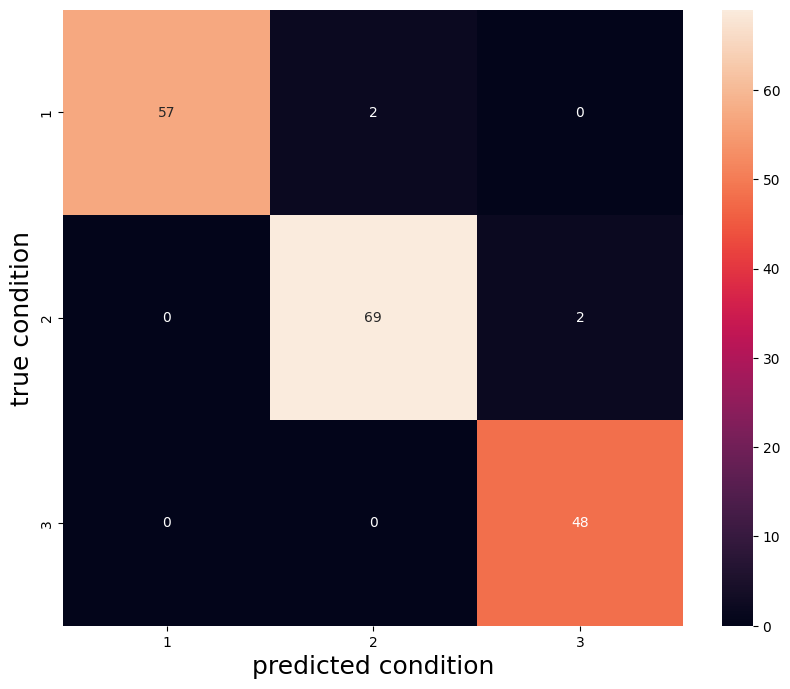

conf_mat:
 [[57  2  0]
 [ 0 69  2]
 [ 0  0 48]]
            precision   recall   accuracy  f1-score   support
       1     1.0    0.97    0.97    0.98     59
       2     0.97    0.97    0.97    0.97     71
       3     0.96    1.0    1.0    0.98     48
avg/total:    0.98    0.98    0.98    0.98     178


In [9]:
confusion_mat(test_y, pre_y)
mat = confusion_mat1(test_y, pre_y)#自定义

#### 高级要求

对于三分类问题为什么要求ROC曲线还不理解...只理解了TP、FP、
TN、FN、TPR、FPR、ROC、AUC的概念，代码也不清楚需要怎么实现。

[[57  2  0]
 [ 0 69  2]
 [ 0  0 48]]


Text(0, 0.5, 'TPR')

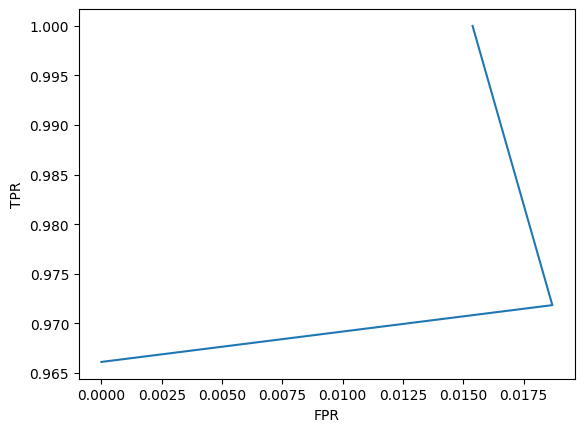

In [10]:
TP = []
FP = []
TN = []
FN = []
TPR = []
FPR = []
print(mat)
for i in range(3):
    TP.append(mat[i][i])
    FP.append(0)
    FN.append(0)
    TN.append(0)
    for j in range(3):
        if j == i:
            continue
        FP[i] += mat[j][i]
        FN[i] += mat[i][j]
        for k in range(3):
            if k == i:
                continue
            TN[i] += mat[j][k]
    TPR.append(TP[i] / (TP[i] + FN[i]))
    FPR.append(FP[i] / (TN[i] + FP[i]))
plt.plot(FPR, TPR, label = 'class 1')
plt.xlabel("FPR")
plt.ylabel("TPR")